In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt # general plotting
import cartopy.crs as ccrs # plot on maps, better than the Basemap module
import re
import scipy.interpolate
from scipy.interpolate import interp1d

In [19]:
ds = xr.open_dataset(".././initial_GEOSChem_rst.2x25_benchmark.nc")
ds # same as print(ds) in IPython/Jupyter environment

<xarray.Dataset>
Dimensions:       (lat: 91, lev: 72, lon: 144, time: 1)
Coordinates:
  * lon           (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
  * lat           (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 ...
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * time          (time) datetime64[ns] 2013-07-01
Data variables:
    AREA          (lat, lon) float64 ...
    SPC_RCOOH     (time, lev, lat, lon) float32 ...
    SPC_O2        (time, lev, lat, lon) float32 ...
    SPC_N2        (time, lev, lat, lon) float32 ...
    SPC_MOH       (time, lev, lat, lon) float32 ...
    SPC_H2        (time, lev, lat, lon) float32 ...
    SPC_O         (time, lev, lat, lon) float32 ...
    SPC_HO2       (time, lev, lat, lon) float32 ...
    SPC_O1D       (time, lev, lat, lon) float32 ...
    SPC_OH        (time, lev, lat, lon) float32 ...
    SPC_MO2       (time, lev, lat, lon) float32 ...
    SPC_MCO3      (time, lev, lat, lon) float32 ...
 

In [20]:
molec = list()
i = 0
pattern = "(SPC_\w+)"
for i, line in enumerate(open('../molecular_species.txt')):
    for match in re.finditer(pattern,line):
        #molec.append(match)
        molec.append(match.group())
lev = np.linspace(1,132,num =132,dtype = 'float64')

In [21]:
dataset = xr.Dataset()
dataset.coords['time'] = ds.coords['time']
dataset.coords['lev'] = (('lev'),lev)
dataset.coords['lat'] = ds.coords['lat'] 
dataset.coords['lon'] = ds.coords['lon']
dataset.attrs['title'] = 'GEOS-5 132 lvl restart'
dataset.attrs['history'] = 'created by Ada Shaw with initial_GEOSChem_rst.c48_benchmark.nc'
dataset.attrs['format'] = "NetCDF-4"
dataset.attrs['conventions'] = 'COARDS'

In [22]:
lon_dim = len(ds['lon'].values)
lat_dim = len(ds['lat'].values)


In [23]:
lev72 = np.reshape(np.repeat(np.linspace(1,72, num=72,dtype = 'float64'),lon_dim),[72,lon_dim])
lev132 = np.reshape(np.repeat(np.linspace(1,72, num=132,dtype = 'float64'),lon_dim),[132,lon_dim])
tick_molec = 1
dr = ds[molec[tick_molec]].values
lon_i =np.transpose(np.reshape(np.repeat(np.linspace(1,len(dr[0,0,0,:]),num= len(dr[0,0,0,:]),dtype ='float64'),72),[lon_dim,72]))
lon_f = np.transpose(np.reshape(np.repeat(np.linspace(1,len(dr[0,0,0,:]),num= len(dr[0,0,0,:]),dtype ='float32'),132),[lon_dim,132]))
conc_interp = np.ndarray(shape=(dr.shape[0],132,dr.shape[2],dr.shape[3]), dtype='f', order='F')

In [24]:
dr.shape

(1, 72, 91, 144)

In [ ]:
for tick_molec in range(len(molec)):
    dr = ds[molec[tick_molec]].values
    for tick_lat in range(lat_dim):
        interp = scipy.interpolate.Rbf(lon_i,lev72 ,dr[0,:,tick_lat,:], function='linear')
        conc_interp[0,:,tick_lat,:] = interp(lon_f,lev132)
    dataset[molec[tick_molec]] = (('time','lev','lat','lon'),interp(lon_f,lev132))
    dataset.data_vars[molec[tick_molec]].attrs = ds.data_vars[molec[tick_molec]].attrs

In [25]:
#check if loop works
tick_molec = 275
dr = ds[molec[tick_molec]].values
for tick_lat in range(lat_dim):
    interp = scipy.interpolate.Rbf(lon_i,lev72 ,dr[0,:,tick_lat,:], function='linear')
    conc_interp[0,:,tick_lat,:] = interp(lon_f,lev132)
dataset[molec[tick_molec]] = (('time','lev','lat','lon'),conc_interp)
dataset.data_vars[molec[tick_molec]].attrs = ds.data_vars[molec[tick_molec]].attrs

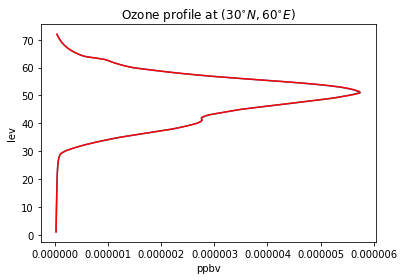

In [29]:
#check if ozone profiles are similar
#72 levels
do3 = ds["SPC_O3"]
lev_72 = do3.sel(lon = 175.0,lat = 88,time = '2013-07-01T00:00:00.000000000')

plt.plot(lev_72, lev_72['lev'])
plt.ylabel('lev');plt.xlabel('ppbv')
plt.title('Ozone profile at $(30^{\circ}N, 60^{\circ}E)$')
#132 levels
do3_interp = dataset['SPC_O3']
lev_132 = do3_interp.sel(lon = 175.,lat = 88.,time = "2013-07-01T00:00:00.000000000")
plt.plot(lev_132, np.linspace(1,72,num=132),'r')

In [27]:
ds['lon'].values

array([-180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5,
       -160. , -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5,
       -140. , -137.5, -135. , -132.5, -130. , -127.5, -125. , -122.5,
       -120. , -117.5, -115. , -112.5, -110. , -107.5, -105. , -102.5,
       -100. ,  -97.5,  -95. ,  -92.5,  -90. ,  -87.5,  -85. ,  -82.5,
        -80. ,  -77.5,  -75. ,  -72.5,  -70. ,  -67.5,  -65. ,  -62.5,
        -60. ,  -57.5,  -55. ,  -52.5,  -50. ,  -47.5,  -45. ,  -42.5,
        -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,  -22.5,
        -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,   -2.5,
          0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
      

In [28]:
ds['lat'].values

array([-89.5, -88. , -86. , -84. , -82. , -80. , -78. , -76. , -74. ,
       -72. , -70. , -68. , -66. , -64. , -62. , -60. , -58. , -56. ,
       -54. , -52. , -50. , -48. , -46. , -44. , -42. , -40. , -38. ,
       -36. , -34. , -32. , -30. , -28. , -26. , -24. , -22. , -20. ,
       -18. , -16. , -14. , -12. , -10. ,  -8. ,  -6. ,  -4. ,  -2. ,
         0. ,   2. ,   4. ,   6. ,   8. ,  10. ,  12. ,  14. ,  16. ,
        18. ,  20. ,  22. ,  24. ,  26. ,  28. ,  30. ,  32. ,  34. ,
        36. ,  38. ,  40. ,  42. ,  44. ,  46. ,  48. ,  50. ,  52. ,
        54. ,  56. ,  58. ,  60. ,  62. ,  64. ,  66. ,  68. ,  70. ,
        72. ,  74. ,  76. ,  78. ,  80. ,  82. ,  84. ,  86. ,  88. ,
        89.5])

In [ ]:
ds.coords['time']

In [ ]:
dataset

In [ ]:
dataset.to_netcdf('132_lvl_rst.nc','w')